## Import Library & Data

In [87]:
from google_play_scraper import app, reviews, Sort, reviews_all

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
from mpstemmer import MPStemmer
import nltk
import emoji
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

import requests
import csv
from io import StringIO
from wordcloud import WordCloud

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from torch.nn.functional import softmax
import random

import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, BertForSequenceClassification, BertConfig, BertTokenizer, AutoModelForSequenceClassification

import os

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/itsgoy21/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/itsgoy21/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/itsgoy21/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:

os.chdir("/mnt/d/Data/My Skill/Analyze Review App Netflix")
print(os.getcwd()) 

/mnt/d/Data/My Skill/Analyze Review App Netflix


In [4]:
scrapreview, _ = reviews(
    'com.spotify.music',
    lang='id',
    country='id',
    sort=Sort.NEWEST,
    count=30000
)

In [5]:
df = pd.DataFrame(scrapreview)
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,8e9231dc-1652-4578-8514-bc0eb2dc5e3f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,""" STOP "" TAWARKAN PREMIUM",1,1,9.0.90.1229,2025-11-19 13:25:15,None,NaT,9.0.90.1229
1,bdf8b35c-c397-4369-b8c7-3e500846f9ed,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"please Spotify, Perbaiki bug pembayaran pulsa ...",1,0,9.0.96.826,2025-11-18 20:57:13,None,NaT,9.0.96.826
2,36261a7b-27aa-4015-ac20-63e961fa2598,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sekarang di batasi ya mendengar kan lagu yang ...,2,2,9.0.94.274,2025-11-17 20:15:32,None,NaT,9.0.94.274
3,1f62260c-08d5-4d7b-bde5-0d3cc9848aef,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Njir milih lagu aja harus premium, maksa bange...",1,1,9.0.82.1032,2025-11-17 20:07:15,"Hai, kami sangat menghargai masukan Anda. Untu...",2025-11-17 23:06:42,9.0.82.1032
4,b57b7c8e-c156-4be5-865a-4144e8d540f2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sangat bagus untuk mendengarkan musik yang di ...,5,0,None,2025-11-17 20:07:12,None,NaT,None


In [6]:
df.to_csv("Review App Spotify.csv", index=False)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              30000 non-null  object        
 1   userName              30000 non-null  object        
 2   userImage             30000 non-null  object        
 3   content               30000 non-null  object        
 4   score                 30000 non-null  int64         
 5   thumbsUpCount         30000 non-null  int64         
 6   reviewCreatedVersion  22309 non-null  object        
 7   at                    30000 non-null  datetime64[ns]
 8   replyContent          2284 non-null   object        
 9   repliedAt             2284 non-null   datetime64[ns]
 10  appVersion            22309 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 2.5+ MB


In [8]:
clean_df = df.drop(columns=['reviewId', 'userImage', 'replyContent', 'repliedAt'])
clean_df = clean_df.dropna()
clean_df = clean_df.drop_duplicates()
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22309 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   userName              22309 non-null  object        
 1   content               22309 non-null  object        
 2   score                 22309 non-null  int64         
 3   thumbsUpCount         22309 non-null  int64         
 4   reviewCreatedVersion  22309 non-null  object        
 5   at                    22309 non-null  datetime64[ns]
 6   appVersion            22309 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 1.4+ MB


## Data Preprocessing

In [9]:
url = "https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/refs/heads/main/kamus_alay.csv"
slangwords = pd.read_csv(url)
slangwords.head()

,slang,formal
0,woww,wow
1,aminn,amin
2,met,selamat
3,netaas,menetas
4,keberpa,keberapa


In [10]:
def casefoldingtext(text):
    text = text.lower()
    return text

def cleaningtext(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'(\w+)²', r'\1', text)
    text = re.sub(r'\b(\w+)\1\b', r'\1', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = " ".join([w for w in text.split() if len(w) > 1])
    text = emoji.demojize(text)
    text = re.sub(':[A-Za-z_-]+:', ' ', text)
    text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text)
    text = text.replace('\n', '')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

normalize_word_dict = {}
for index, row in slangwords.iterrows():
    if row[0] not in normalize_word_dict:
        normalize_word_dict[row[0]] = row[1]

def fix_slangwords(text):
    list_text = word_tokenize(text)
    list_text = [normalize_word_dict[term] if term in normalize_word_dict else term for term in list_text]
    text = " ".join(list_text)
    return text

def tokenizingtext(text):
    text = word_tokenize(text)
    return text

stemmer = MPStemmer()
cache ={}
def stemmingtext(words):
    stemmed_words = []
    for word in words:
        if word in cache:
            stemmed_words.append(cache[word])
        else:
            stem = stemmer.stem(word)
            cache[word] = stem
            stemmed_words.append(stem)
    return stemmed_words

def filteringtext(text):
    factory = StopWordRemoverFactory()
    listStopwords = set(factory.get_stop_words())
    listStopwords1 = set(stopwords.words('indonesian'))
    listStopwords2 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(listStopwords2)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = [txt for txt in text if txt not in listStopwords]
    text = filtered
    return text

def tosentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

/tmp/ipykernel_739/2189585805.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in normalize_word_dict:
/tmp/ipykernel_739/2189585805.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalize_word_dict[row[0]] = row[1]


In [11]:
teks = "  auuuu mau      memberi makan gaga tidak berguna      "
tokens = word_tokenize(teks)
print(cleaningtext(teks))
print(stemmingtext(tokens))
print(filteringtext(tokens))  

au mau memberi makan ga tidak berguna
['auuuu', 'mau', 'beri', 'makan', 'gaga', 'tidak', 'guna']
['auuuu', 'makan', 'gaga', 'berguna']


In [12]:
clean_df['text_casefoldingText'] = clean_df['content'].apply(casefoldingtext)
clean_df['text_clean'] = clean_df['text_casefoldingText'].apply(cleaningtext)
clean_df['text_slangwords'] = clean_df['text_clean'].apply(fix_slangwords)
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingtext)
clean_df['text_stemming'] = clean_df['text_tokenizingText'].apply(stemmingtext)
clean_df['text_stopwords'] = clean_df['text_stemming'].apply(filteringtext)
clean_df['text_akhir'] = clean_df['text_stopwords'].apply(tosentence)

In [13]:
clean_df.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,text_casefoldingText,text_clean,text_slangwords,text_tokenizingText,text_stemming,text_stopwords,text_akhir
0,Pengguna Google,""" STOP "" TAWARKAN PREMIUM",1,1,9.0.90.1229,2025-11-19 13:25:15,9.0.90.1229,""" stop "" tawarkan premium",stop tawarkan premium,stop tawarkan premium,"[stop, tawarkan, premium]","[stop, tawar, premium]","[stop, tawar, premium]",stop tawar premium
1,Pengguna Google,"please Spotify, Perbaiki bug pembayaran pulsa ...",1,0,9.0.96.826,2025-11-18 20:57:13,9.0.96.826,"please spotify, perbaiki bug pembayaran pulsa ...",please spotify perbaiki bug pembayaran pulsa y...,please spotify perbaiki bug pembayaran pulsa y...,"[please, spotify, perbaiki, bug, pembayaran, p...","[please, spotify, baik, bug, bayar, pulsa, yan...","[please, spotify, bug, bayar, pulsa, gagal, pu...",please spotify bug bayar pulsa gagal pulsa bel...
2,Pengguna Google,sekarang di batasi ya mendengar kan lagu yang ...,2,2,9.0.94.274,2025-11-17 20:15:32,9.0.94.274,sekarang di batasi ya mendengar kan lagu yang ...,sekarang di batasi ya mendengar kan lagu yang ...,sekarang di batasi ya mendengar kan lagu yang ...,"[sekarang, di, batasi, ya, mendengar, kan, lag...","[sekarang, di, batas, iya, dengar, kan, lagu, ...","[batas, dengar, lagu, kali, kali, please, kasi...",batas dengar lagu kali kali please kasih ruang...
3,Pengguna Google,"Njir milih lagu aja harus premium, maksa bange...",1,1,9.0.82.1032,2025-11-17 20:07:15,9.0.82.1032,"njir milih lagu aja harus premium, maksa bange...",njir milih lagu aja harus premium maksa banget...,anjir memilih lagu saja harus premium maksa ba...,"[anjir, memilih, lagu, saja, harus, premium, m...","[anjir, pilih, lagu, saja, harus, premium, pak...","[anjir, pilih, lagu, premium, paksa, banget, o...",anjir pilih lagu premium paksa banget orang be...
7,Pengguna Google,mudah mencari dan menemukan lagu terbaru,5,0,9.0.94.274,2025-11-17 20:02:28,9.0.94.274,mudah mencari dan menemukan lagu terbaru,mudah mencari dan menemukan lagu terbaru,mudah mencari dan menemukan lagu terbaru,"[mudah, mencari, dan, menemukan, lagu, terbaru]","[mudah, cari, dan, temu, lagu, baru]","[mudah, cari, temu, lagu]",mudah cari temu lagu


In [14]:
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/fajri91/InSet/refs/heads/master/positive.tsv')

if response.status_code == 200:
  reader = pd.read_csv(StringIO(response.text), sep='\t', header=0)

  for idx, row in reader.iterrows():
    lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/fajri91/InSet/refs/heads/master/negative.tsv')

if response.status_code == 200:
  reader = pd.read_csv(StringIO(response.text),  sep='\t', header=0)

  for idx, row in reader.iterrows():
    lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")
    
def sentiment_analysis_lexicon_indonesia(text):
  score = 0
  for word in text:
    if (word in lexicon_positive):
      score = score + lexicon_positive[word]
  for word in text:
    if (word in lexicon_negative):
      score = score + lexicon_negative[word]
  polarity = ''
  if (score > 0):
    polarity = 'positive'
  elif (score < 0):
    polarity = 'negative'
  else:
    polarity = 'neutral'

  return score, polarity

results = clean_df['text_stopwords'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

/tmp/ipykernel_739/2553671718.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lexicon_positive[row[0]] = int(row[1])
/tmp/ipykernel_739/2553671718.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lexicon_negative[row[0]] = int(row[1])


polarity
positive    9716
negative    7722
neutral     4871
Name: count, dtype: int64


In [15]:
clean_df.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,text_casefoldingText,text_clean,text_slangwords,text_tokenizingText,text_stemming,text_stopwords,text_akhir,polarity_score,polarity
0,Pengguna Google,""" STOP "" TAWARKAN PREMIUM",1,1,9.0.90.1229,2025-11-19 13:25:15,9.0.90.1229,""" stop "" tawarkan premium",stop tawarkan premium,stop tawarkan premium,"[stop, tawarkan, premium]","[stop, tawar, premium]","[stop, tawar, premium]",stop tawar premium,-2,negative
1,Pengguna Google,"please Spotify, Perbaiki bug pembayaran pulsa ...",1,0,9.0.96.826,2025-11-18 20:57:13,9.0.96.826,"please spotify, perbaiki bug pembayaran pulsa ...",please spotify perbaiki bug pembayaran pulsa y...,please spotify perbaiki bug pembayaran pulsa y...,"[please, spotify, perbaiki, bug, pembayaran, p...","[please, spotify, baik, bug, bayar, pulsa, yan...","[please, spotify, bug, bayar, pulsa, gagal, pu...",please spotify bug bayar pulsa gagal pulsa bel...,-14,negative
2,Pengguna Google,sekarang di batasi ya mendengar kan lagu yang ...,2,2,9.0.94.274,2025-11-17 20:15:32,9.0.94.274,sekarang di batasi ya mendengar kan lagu yang ...,sekarang di batasi ya mendengar kan lagu yang ...,sekarang di batasi ya mendengar kan lagu yang ...,"[sekarang, di, batasi, ya, mendengar, kan, lag...","[sekarang, di, batas, iya, dengar, kan, lagu, ...","[batas, dengar, lagu, kali, kali, please, kasi...",batas dengar lagu kali kali please kasih ruang...,-3,negative
3,Pengguna Google,"Njir milih lagu aja harus premium, maksa bange...",1,1,9.0.82.1032,2025-11-17 20:07:15,9.0.82.1032,"njir milih lagu aja harus premium, maksa bange...",njir milih lagu aja harus premium maksa banget...,anjir memilih lagu saja harus premium maksa ba...,"[anjir, memilih, lagu, saja, harus, premium, m...","[anjir, pilih, lagu, saja, harus, premium, pak...","[anjir, pilih, lagu, premium, paksa, banget, o...",anjir pilih lagu premium paksa banget orang be...,-2,negative
7,Pengguna Google,mudah mencari dan menemukan lagu terbaru,5,0,9.0.94.274,2025-11-17 20:02:28,9.0.94.274,mudah mencari dan menemukan lagu terbaru,mudah mencari dan menemukan lagu terbaru,mudah mencari dan menemukan lagu terbaru,"[mudah, mencari, dan, menemukan, lagu, terbaru]","[mudah, cari, dan, temu, lagu, baru]","[mudah, cari, temu, lagu]",mudah cari temu lagu,4,positive


In [16]:
clean_df.to_csv("Clean DataSet Review App Spotify.csv", index=False)

## EDA

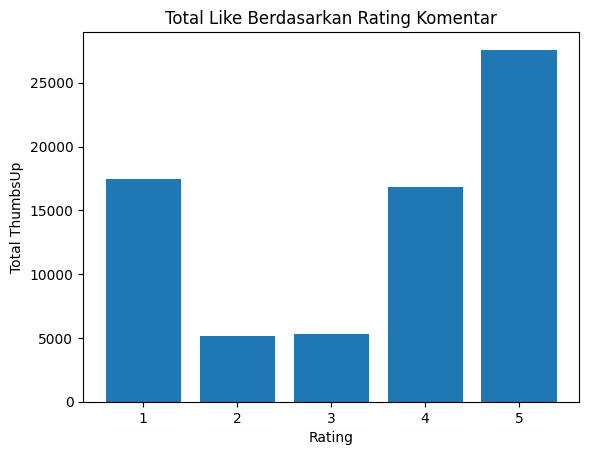

In [17]:
score_group = clean_df.groupby('score')['thumbsUpCount'].sum()
plt.bar(score_group.index, score_group.values)
plt.xlabel('Rating')
plt.ylabel('Total ThumbsUp')
plt.title('Total Like Berdasarkan Rating Komentar')
plt.show()

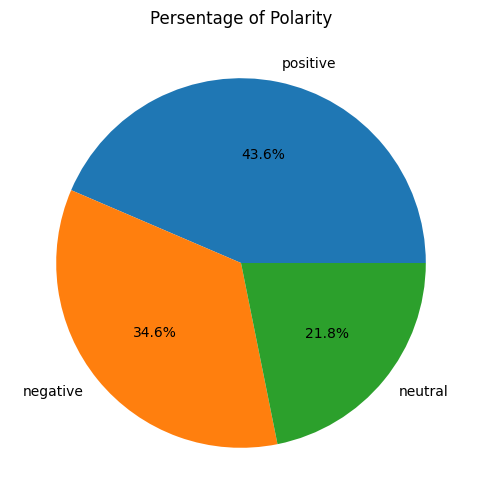

In [18]:
polarity_persentage = clean_df['polarity'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(polarity_persentage, labels=polarity_persentage.index, autopct='%1.1f%%')
plt.title("Persentage of Polarity")
plt.show()

In [19]:
polarity_positive = clean_df[clean_df['polarity'] == 'positive']
polarity_negative = clean_df[clean_df['polarity'] == 'negative']
polarity_neutral = clean_df[clean_df['polarity'] == 'neutral']

all_teks_positive = ' '.join(polarity_positive['text_akhir'])
all_teks_negative = ' '.join(polarity_negative['text_akhir'])
all_teks_neutral = ' '.join(polarity_neutral['text_akhir'])

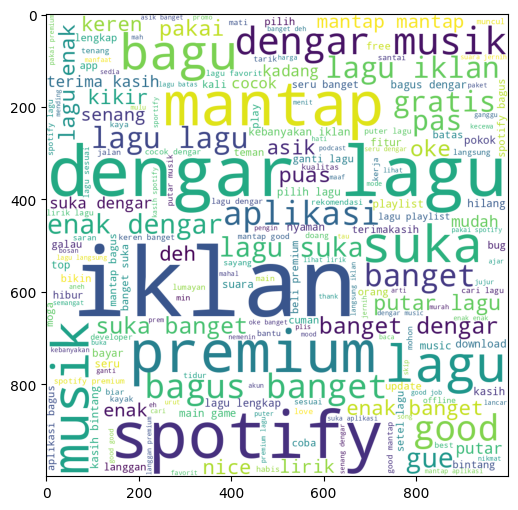

In [20]:
wordcloud = WordCloud(width=1000, height=1000, background_color='white').generate(all_teks_positive)
plt.figure(figsize=(6, 6))
plt.imshow(wordcloud)
plt.show()

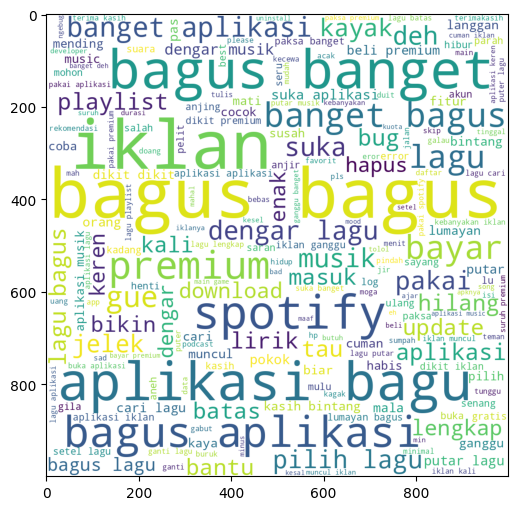

In [21]:
wordcloud = WordCloud(width=1000, height=1000, background_color='white').generate(all_teks_negative)
plt.figure(figsize=(6, 6))
plt.imshow(wordcloud)
plt.show()

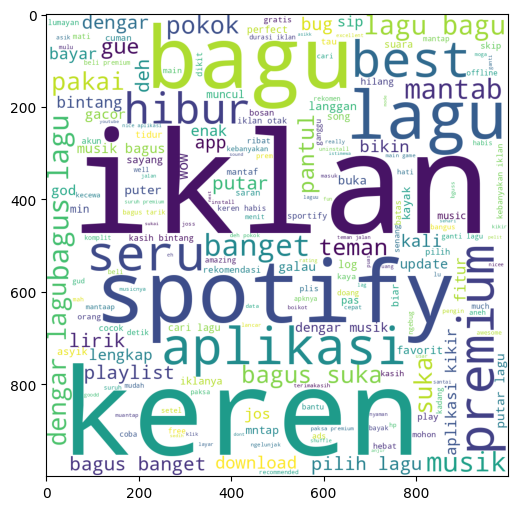

In [22]:
wordcloud = WordCloud(width=1000, height=1000, background_color='white').generate(all_teks_neutral)
plt.figure(figsize=(6, 6))
plt.imshow(wordcloud)
plt.show()

## Undersampling

In [42]:
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(clean_df[["text_akhir"]], clean_df["polarity"])
print(Counter(y_resampled))

Counter({'negative': 4871, 'neutral': 4871, 'positive': 4871})


In [43]:
X_resampled = X_resampled["text_akhir"]

## Data Spliting

In [44]:
le = LabelEncoder()
y = le.fit_transform(y_resampled)
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(4871), np.int64(1): np.int64(4871), np.int64(2): np.int64(4871)}


In [83]:
print(le.classes_)

['negative' 'neutral' 'positive']


In [61]:
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y, test_size=0.3, random_state=42, stratify=y)
X_eval, X_test, y_eval, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42, stratify=y_temp)

In [62]:
print("Train size:", len(X_train))
print("Eval size :", len(X_eval))
print("Test size :", len(X_test))

Train size: 10229
Eval size : 1753
Test size : 2631


## IndoBert with PyTorch

In [63]:
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")

def tokenize_text(text_series, max_len=128):
    encoded = tokenizer(
        text_series.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )
    return encoded

X_train_enc = tokenize_text(X_train)
X_test_enc  = tokenize_text(X_test)
X_eval_enc  = tokenize_text(X_eval)

In [64]:
def create_dataset(encoded, labels):
    dataset = TensorDataset(
        encoded["input_ids"],
        encoded["attention_mask"],
        torch.tensor(labels, dtype=torch.long)
    )
    return dataset
    
train_dataset = create_dataset(X_train_enc, y_train)
test_dataset  = create_dataset(X_test_enc, y_test)
eval_dataset  = create_dataset(X_eval_enc, y_eval)

In [ ]:
def create_dataloader(dataset, batch_size=8, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    

train_loader = create_dataloader(train_dataset, batch_size=8, shuffle=True)
test_loader  = create_dataloader(test_dataset, batch_size=8, shuffle=False)
eval_loader  = create_dataloader(eval_dataset, batch_size=8, shuffle=False)

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [72]:
model = AutoModelForSequenceClassification.from_pretrained(
    "indolem/indobert-base-uncased",
    num_labels=3,
    hidden_dropout_prob = 0.1
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
scaler = torch.amp.GradScaler('cuda')

for epoch in range(5):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in eval_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Eval Acc: {acc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Train Loss: 0.5587 | Eval Acc: 0.8659 | F1: 0.8661 | Precision: 0.8718 | Recall: 0.8659
Epoch 2 | Train Loss: 0.3398 | Eval Acc: 0.8916 | F1: 0.8916 | Precision: 0.8957 | Recall: 0.8916
Epoch 3 | Train Loss: 0.2572 | Eval Acc: 0.9030 | F1: 0.9033 | Precision: 0.9097 | Recall: 0.9030
Epoch 4 | Train Loss: 0.2042 | Eval Acc: 0.9184 | F1: 0.9182 | Precision: 0.9221 | Recall: 0.9184
Epoch 5 | Train Loss: 0.1590 | Eval Acc: 0.9144 | F1: 0.9144 | Precision: 0.9145 | Recall: 0.9144


In [73]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

print("Accuracy:", correct / total)


Accuracy: 0.9076396807297605


In [74]:
model.save_pretrained('saved_mode/indobert-sentiment')
tokenizer.save_pretrained('saved_mode/indobert-sentiment')

('saved_mode/indobert-sentiment/tokenizer_config.json',
 'saved_mode/indobert-sentiment/special_tokens_map.json',
 'saved_mode/indobert-sentiment/vocab.txt',
 'saved_mode/indobert-sentiment/added_tokens.json',
 'saved_mode/indobert-sentiment/tokenizer.json')

In [123]:
texts = ["aplikasinya bagus banget enak kalo lagi santai"]

# Tokenize
encoded_input = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
).to(device)

# Eval
model.eval()
with torch.no_grad():
    outputs = model(**encoded_input)
    logits = outputs.logits

# Softmax untuk probabilitas tiap kelas
probs = softmax(logits, dim=1)
probs = probs.cpu().numpy()

label_map = {0: "negative", 1: "neutral", 2: "positive"}

for i, text in enumerate(texts):
    print(f"Text: {text}")
    for j, p in enumerate(probs[i]):
        print(f"Class '{label_map[j]}': {p:.4f}")

Text: aplikasinya bagus banget enak kalo lagi santai
Class 'negative': 0.3443
Class 'neutral': 0.2990
Class 'positive': 0.3567


## IndoBert with Tensor Flow

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

def encode(texts, labels):
    tokens = tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors='tf'
    )
    return tokens, tf.convert_to_tensor(labels.tolist())

X_train_tok, y_train_tf = encode(X_train, y_train)
X_eval_tok, y_eval_tf = encode(X_eval, y_eval)
X_test_tok, y_test_tf = encode(X_test, y_test)

In [ ]:
num_labels = len(set(y))

model = TFAutoModelForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels=num_labels
)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy("accuracy")]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history = model.fit(
    dict(input_ids=X_train_tok["input_ids"], attention_mask=X_train_tok["attention_mask"]),
    y_train_tf,
    validation_data=(
        dict(input_ids=X_eval_tok["input_ids"], attention_mask=X_eval_tok["attention_mask"]),
        y_eval_tf
    ),
    epochs=5,         
    batch_size=16
)

In [ ]:
results = model.evaluate(
    dict(input_ids=X_test_tok["input_ids"], attention_mask=X_test_tok["attention_mask"]),
    y_test_tf
)

print("\n🔹 Test Loss:", results[0])
print("🔹 Test Accuracy:", results[1])

In [ ]:
texts = ["Pelayanan buruk sekali", "bagus banget", "enak banget"]
enc = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="tf")
preds = model.predict(enc)

pred_labels = tf.argmax(preds.logits, axis=1).numpy()
labels_name = le.inverse_transform(pred_labels)
print("\nPrediksi label:", labels_name)

In [ ]:
model.predict(tokenizer(["bagus"], return_tensors="tf", padding=True, truncation=True))


In [ ]:
for i, text in enumerate(X):
    if "bagus" in text.lower():
        print(i, y[i], "-", text)

In [ ]:
model.save_pretrained("./my_model")


In [ ]:
tokenizer.save_pretrained("./my_model")

In [ ]:
import json

label2id = {label: int(i) for i, label in enumerate(le.classes_)}
id2label = {int(i): label for i, label in enumerate(le.classes_)}


with open("./my_model/labels.json", "w") as f:
    json.dump({
        "label2id": label2id,
        "id2label": id2label
    }, f)
